## Imports

In [1]:
import pandas as pd

from sklearn import preprocessing
from collections import deque
import numpy as np
import random
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
# pt CuDNNLSTM look at this https://stackoverflow.com/questions/60468385/is-there-cudnnlstm-or-cudnngru-alternative-in-tensorflow-2-0

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

The next steps are as follow:
### 1. create the main dataframe
### 2. load the data

In [2]:
main_df = pd.DataFrame()

ratios = ["BCH-USD", "BTC-USD", "ETH-USD", "LTC-USD"]

for ratio in ratios:
    dataset = pd.read_csv(
        f"crypto_data/{ratio}.csv",
        names=["time", "low", "high", "open", "close", "volume"],
    )
    # we only need the close and volume
    dataset.rename(
        columns={"close": f"{ratio}-close", "volume": f"{ratio}-volume"}, inplace=True
    )
    # print(dataset.head())

    # set the time as the index
    dataset.set_index("time", inplace=True)

    # drop the ones we don't need
    dataset.drop(["low", "high", "open"], axis=1, inplace=True)

    # merge all the columns on the index
    if main_df.empty:
        main_df = dataset
    else:
        main_df = main_df.join(dataset)

In [3]:
main_df.head()

,BCH-USD-close,BCH-USD-volume,BTC-USD-close,BTC-USD-volume,ETH-USD-close,ETH-USD-volume,LTC-USD-close,LTC-USD-volume
time,,,,,,,,
1528968660,871.719971,5.675361,6489.549805,0.587100,NaN,NaN,96.580002,9.647200
1528968720,870.859985,26.856577,6487.379883,7.706374,486.01001,26.019083,96.660004,314.387024
1528968780,870.099976,1.124300,6479.410156,3.088252,486.00000,8.449400,96.570000,77.129799
1528968840,870.789978,1.749862,6479.410156,1.404100,485.75000,26.994646,96.500000,7.216067
1528968900,870.000000,1.680500,6479.979980,0.753000,486.00000,77.355759,96.389999,524.539978


In [4]:
main_df.columns.values

array(['BCH-USD-close', 'BCH-USD-volume', 'BTC-USD-close',
       'BTC-USD-volume', 'ETH-USD-close', 'ETH-USD-volume',
       'LTC-USD-close', 'LTC-USD-volume'], dtype=object)

## Define the parameters of the dataset.

In [5]:
SEQ_LEN = 60
FUTURE_PRED = 60
COIN = "BTC-USD"
VAL_PCT = 0.20

## Create a classifier that specifies when to buy/sell


In [6]:
def classify(current, future):
    if float(current) <= float(future):
        return 1 # when the price is higher we buy
    else:
        return 0 # when the price is lower we sell

## Let's do some feature engineering
- add a 'future' column
- add a 'target' column

In [7]:
main_df["future"] = main_df[f"{COIN}-close"].shift(-FUTURE_PRED)
main_df[[f'{COIN}-close', 'future']].head()

,BTC-USD-close,future
time,,
1528968660,6489.549805,6485.000000
1528968720,6487.379883,6484.990234
1528968780,6479.410156,6493.399902
1528968840,6479.410156,6487.830078
1528968900,6479.979980,6487.830078


In [8]:
main_df["target"] = list(
    map(classify, main_df[f"{COIN}-close"], main_df["future"])
)
main_df.head()

,BCH-USD-close,BCH-USD-volume,BTC-USD-close,BTC-USD-volume,ETH-USD-close,ETH-USD-volume,LTC-USD-close,LTC-USD-volume,future,target
time,,,,,,,,,,
1528968660,871.719971,5.675361,6489.549805,0.587100,NaN,NaN,96.580002,9.647200,6485.000000,0
1528968720,870.859985,26.856577,6487.379883,7.706374,486.01001,26.019083,96.660004,314.387024,6484.990234,0
1528968780,870.099976,1.124300,6479.410156,3.088252,486.00000,8.449400,96.570000,77.129799,6493.399902,1
1528968840,870.789978,1.749862,6479.410156,1.404100,485.75000,26.994646,96.500000,7.216067,6487.830078,1
1528968900,870.000000,1.680500,6479.979980,0.753000,486.00000,77.355759,96.389999,524.539978,6487.830078,1


## Split the data into training and validation sets

In [9]:
times = main_df.index.values
last_x_pct = main_df.index.values[-int(VAL_PCT * len(times))]

validation_main_df = main_df[main_df.index >= last_x_pct]
main_df = main_df[main_df.index < last_x_pct]

main_df.loc[main_df.index == last_x_pct] #the splitting place

,BCH-USD-close,BCH-USD-volume,BTC-USD-close,BTC-USD-volume,ETH-USD-close,ETH-USD-volume,LTC-USD-close,LTC-USD-volume,future,target
time,,,,,,,,,,


In [10]:
main_df.describe()

,BCH-USD-close,BCH-USD-volume,BTC-USD-close,BTC-USD-volume,ETH-USD-close,ETH-USD-volume,LTC-USD-close,LTC-USD-volume,future,target
count,73780.000000,73780.000000,68659.000000,68659.000000,73625.000000,73625.000000,73107.000000,73107.000000,68659.000000,73780.000000
mean,762.449577,11.751972,6868.055547,6.258522,455.072312,49.440810,82.332467,118.398840,6867.720904,0.462591
std,73.228726,34.029166,682.278698,16.738563,38.534674,129.805149,8.303777,272.419967,682.557930,0.498602
min,559.479980,0.000002,5778.109863,0.001915,326.320007,0.000030,58.290001,0.009593,5778.109863,0.000000
25%,708.580017,0.420771,6350.584961,0.864259,434.299988,5.499268,77.279999,12.922469,6350.109863,0.000000
50%,759.000000,2.020262,6635.700195,2.077186,461.700012,14.897300,82.339996,35.887356,6635.700195,0.000000
75%,819.140015,9.129493,7415.069824,5.135763,475.200012,42.180565,86.150002,106.874336,7415.069824,1.000000
max,927.000000,1520.833862,8482.799805,471.660889,547.000000,9310.024414,103.040001,10263.191406,8482.799805,1.000000


In [11]:
missing_target_values_pct = main_df['future'].isna().sum() * 100 /len(main_df['future'])
print(f'{missing_target_values_pct:0.3}%')

6.94%


There are 6% missing values in the target column alone.

In [12]:
main_df.isna().sum()

BCH-USD-close        0
BCH-USD-volume       0
BTC-USD-close     5121
BTC-USD-volume    5121
ETH-USD-close      155
ETH-USD-volume     155
LTC-USD-close      673
LTC-USD-volume     673
future            5121
target               0
dtype: int64

In [13]:
main_df.shape

(73780, 10)

## We now remove/fill in the missing values with values that we believe to be correct.

In [14]:
main_df.fillna(method="ffill", inplace=True)
validation_main_df.fillna(method="ffill", inplace=True)

main_df.dropna(inplace=True)
validation_main_df.dropna(inplace=True)
main_df.isna().sum(), validation_main_df.isna().sum()

(BCH-USD-close     0
 BCH-USD-volume    0
 BTC-USD-close     0
 BTC-USD-volume    0
 ETH-USD-close     0
 ETH-USD-volume    0
 LTC-USD-close     0
 LTC-USD-volume    0
 future            0
 target            0
 dtype: int64,
 BCH-USD-close     0
 BCH-USD-volume    0
 BTC-USD-close     0
 BTC-USD-volume    0
 ETH-USD-close     0
 ETH-USD-volume    0
 LTC-USD-close     0
 LTC-USD-volume    0
 future            0
 target            0
 dtype: int64)

### The data is still not ready for processing. There is one last step required: preprocessing.
# Normalizing, Scaling and Balancing the dataset

The steps required are: dropping the future column, creating pct_change so that the data is clearer and normalizare + scale the data.

# SEQ_LEN
With a normal dataset, we would randomize the order in which the data is so that the model doesn't overfit; instead it learns on random data.

We can't do that here cuz the data would be too random and the model can't learn. Instead, what we'll do is take sequences of predefined lengths then shuffle those sequences. It's a really smart thing to do. We get continuous 1 hour (60 mins) periods and then shuffle them around.

In [15]:
def preprocessing_df(df):
    df.drop("future", axis=1)  # we drop the future column

    # use pct change to figure the change in price
    for col in df.columns:
        if col != "target":
            df[col] = df[col].pct_change()
            df.dropna(inplace=True)

            # normalize the data 0 -> 1 NOTE: normalization is a form of scaling
            df[col] = preprocessing.scale(df[col])
    df.dropna(inplace=True)
    sequencial_data = []
    prev_days = deque(maxlen=SEQ_LEN)
    for row in df.values:
        prev_days.append([x for x in row[:-1]])
        if len(prev_days) == SEQ_LEN:
            #separate the label/target
            sequencial_data.append([np.array(prev_days), row[-1]])

    random.shuffle(sequencial_data)

    """
    the last step in our preprocessing will be to balance the learning set
    """
    buys = []
    sells = []

    for seq, target in sequencial_data:
        if target == 0: # you need to sell
            sells.append([seq, target])
        elif target == 1: # you need to buy
            buys.append([seq, target])

    random.shuffle(buys)
    random.shuffle(sells)

    # how do we balance? Simple. we remove the excess

    lower_nr = min(len(buys), len(sells))

    buys = buys[:lower_nr]
    sells = sells[:lower_nr]

    sequencial_data = buys + sells

    random.shuffle(sequencial_data)

    # split into x and Y
    x = []
    Y = []

    for seq, target in sequencial_data:
        x.append(seq)
        Y.append(target)
    return np.array(x), np.array(Y)

In [16]:
train_x, train_Y = preprocessing_df(main_df)
test_x, test_Y = preprocessing_df(validation_main_df)

In [17]:
print(f"Training data: {len(train_x)}, Validation data: {len(test_x)}")
print(f" Training set Sells: {(train_Y.astype('int32') == 0).sum()}, Buys: {(train_Y.astype('int32') == 1).sum()}")
print(f" Validation set Sells: {(test_Y.astype('int32') == 0).sum()}, Buys: {(test_Y.astype('int32') == 1).sum()}")

Training data: 68188, Validation data: 17404
 Training set Sells: 34094, Buys: 34094
 Validation set Sells: 8702, Buys: 8702


As we can see, the total of entries is 68.010 + 17.120 = 85130 (after filling/dropping the missing values) and the ratio is 80/20.

# Now that the preprocessing is complete, we can go and train the model.

In [18]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

model = Sequential()
model.add(LSTM(64, kernel_regularizer=l2(1e-6), recurrent_regularizer=l2(1e-6), bias_regularizer=l2(1e-6), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(64, kernel_regularizer=l2(1e-6), recurrent_regularizer=l2(1e-6), bias_regularizer=l2(1e-6), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(64, kernel_regularizer=l2(1e-6), recurrent_regularizer=l2(1e-6), bias_regularizer=l2(1e-6)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

# Learning rate Finder

In [19]:
from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K

class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if math.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[tensorboard, callback])

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)

In [20]:
opt = Adam(learning_rate=1e-4, decay=1e-7)

# opt = Adam(learning_rate=0.01)
# tf.summary.scalar('learning rate', data=1e-10)
# lr = ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10, decay_rate=.1)
# opt = SGD(learning_rate=learning_rate)
LOSS='sparse_categorical_crossentropy'

# learning_rate = tf.compat.v1.train.exponential_decay(1e-10, global_step=global_step, decay_steps=100, decay_rate=1.3)

model.compile(loss=LOSS, optimizer=opt, metrics=['accuracy'])

## Hyperparameters, tensorboard and checkpoint

In [21]:
EPOCHS = 10
BATCH_SIZE = 32
# NAME = f"{COIN}-{SEQ_LEN}-{FUTURE_PRED}-VALID-PCT-{VAL_PCT}-LOSS-{LOSS}-OPT-{'Adam'}-{int(time.time())}"
# NAME = f"{COIN}-{SEQ_LEN}-{FUTURE_PRED}-VALID-PCT-model-without-normalization-LOSS-{LOSS}-OPT-{'SGD'}-{int(time.time())}"
NAME = f"LRFinder-{COIN}-{SEQ_LEN}-{FUTURE_PRED}-{int(time.time())}"

In [22]:
tensorboard = TensorBoard(log_dir=f'logs/{NAME}')
filepath = "RNN_Final-{epoch:02d}-{val_accuracy:.3f}"
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

# Fitting the model

In [23]:
"""
for now this is deprecated

history = model.fit(train_x, train_Y, 
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS,
        validation_data=(test_x, test_Y),
        # callbacks=[tensorboard, checkpoint])
        callbacks=[tensorboard])

"""

'\nfor now this is deprecated\n\nhistory = model.fit(train_x, train_Y, \n        batch_size=BATCH_SIZE, \n        epochs=EPOCHS,\n        validation_data=(test_x, test_Y),\n        # callbacks=[tensorboard, checkpoint])\n        callbacks=[tensorboard])\n\n'

Epoch 1/10
533/533 [==============================] - 33s 37ms/step - loss: 0.9740 - accuracy: 0.4887
Epoch 2/10
533/533 [==============================] - 18s 33ms/step - loss: 0.9834 - accuracy: 0.4847
Epoch 3/10
533/533 [==============================] - 23s 43ms/step - loss: 0.9852 - accuracy: 0.4846
Epoch 4/10
533/533 [==============================] - 23s 44ms/step - loss: 0.9584 - accuracy: 0.4894
Epoch 5/10
533/533 [==============================] - 19s 36ms/step - loss: 0.8003 - accuracy: 0.5584
Epoch 6/10
533/533 [==============================] - 17s 33ms/step - loss: 0.4603 - accuracy: 0.7795
Epoch 7/10
533/533 [==============================] - 20s 37ms/step - loss: 0.2169 - accuracy: 0.9148
Epoch 8/10
533/533 [==============================] - 22s 41ms/step - loss: 0.3938 - accuracy: 0.7908
Epoch 9/10
533/533 [==============================] - 0s 6us/step - loss: 0.7371 - accuracy: 0.4922


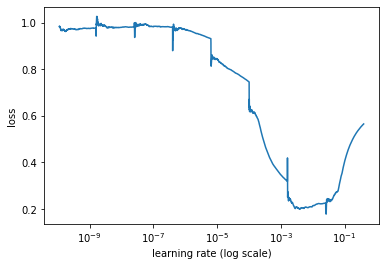

In [24]:
lr_finder = LRFinder(model)
lr_finder.find(train_x,train_Y, start_lr=1e-10, end_lr=100, batch_size=128, epochs=10)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
plt.show()

# Score and saving the model

In [25]:
# Scoring
score = model.evaluate(test_x, test_Y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Saving
model.save(f"models/{NAME}")

Test loss: 0.7401729822158813
Test accuracy: 0.5
INFO:tensorflow:Assets written to: models/LRFinder-BTC-USD-60-60-1615192126\assets
INFO:tensorflow:Assets written to: models/LRFinder-BTC-USD-60-60-1615192126\assets


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 64)            18944     
_________________________________________________________________
dropout (Dropout)            (None, 60, 64)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 64)            256       
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 64)            256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                3

In [27]:
predicted = model.predict(test_x)
expected = test_Y
expected[0]
predicted[0]

array([0.6064976 , 0.39350238], dtype=float32)

In [28]:
from sklearn.metrics import confusion_matrix


predicted_final = np.argmax(predicted, axis=1)
confusion_matrix(expected, predicted_final)

array([[8702,    0],
       [8702,    0]], dtype=int64)

In [29]:
(test_x==1).sum()

0

## According to the documentation, C1,0 is the value of the false negatives and C0,1 is the value of the false positives.

## The top row contains the actual class and the column contains the predicted class.
<pre>
predicted\ Actual|          |
class     \ class|  1(buy)  | 0(sell)   
___________\_____|__________|_________
1(buy)           |   8701   |    1
_________________|__________|_________
0(sell)          |   3968   |   4734
_________________|__________|_________
</pre>      


## Interpreting the model we understand that the model bought when it should have sold 1 time and sold ~4000 times when it should have bought.

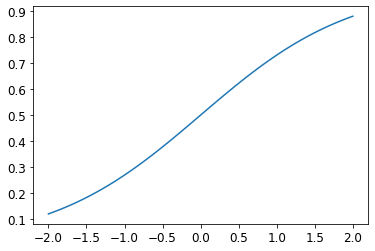

In [30]:
from fastai.vision.all import *
from fastbook import *

plot_function(F.sigmoid)